In [27]:
import OpenEXR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from math import *
from tqdm.auto import tqdm, trange
from tqdm.contrib import itertools as ti
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False

<Figure size 2000x30000 with 0 Axes>

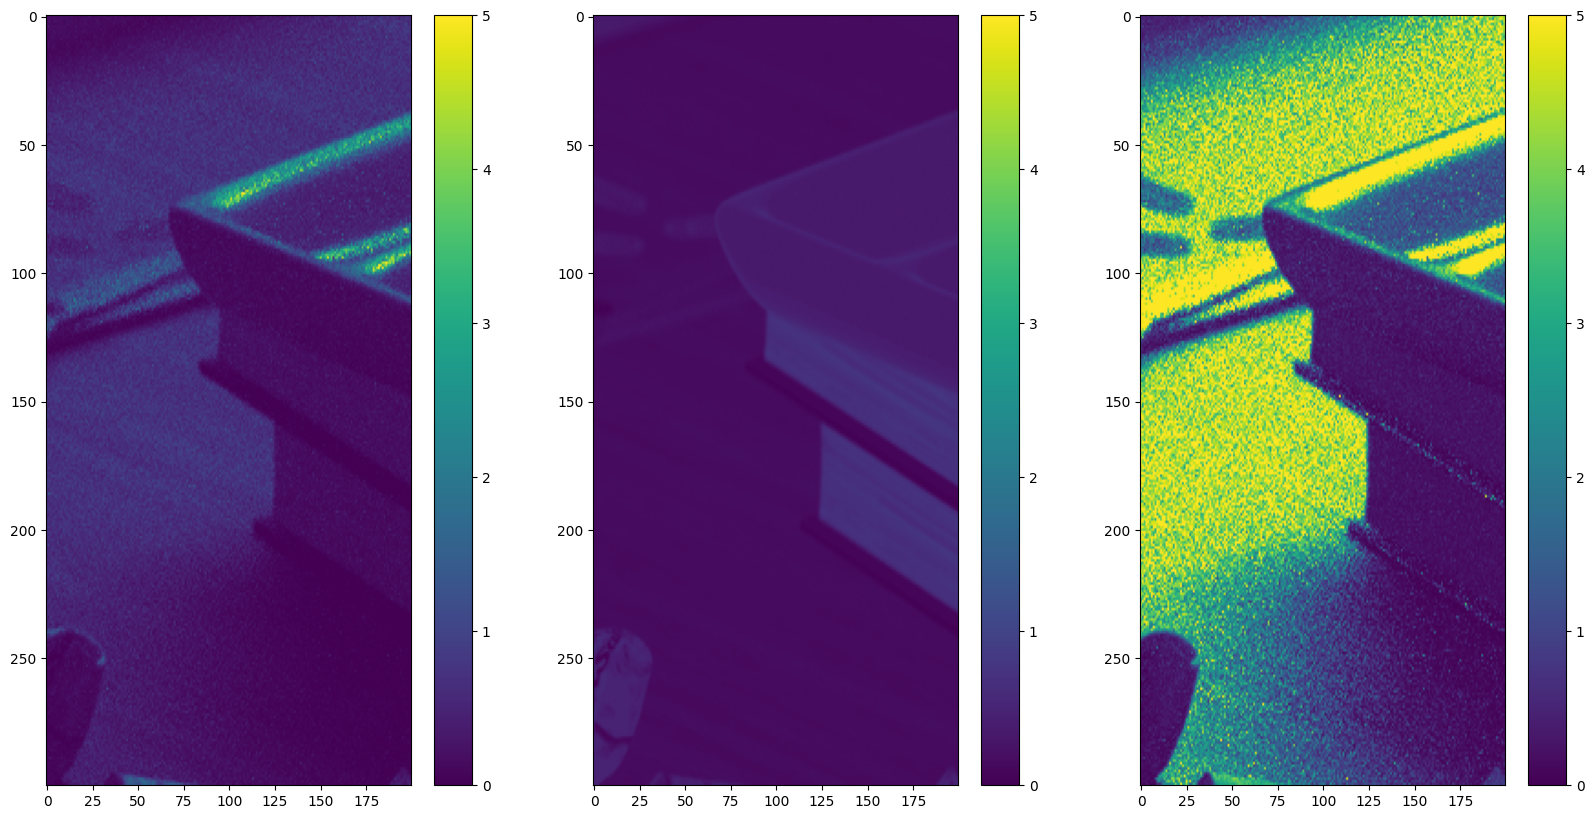

In [37]:
def get_channel(exr, channel):
  raw_bytes = exr.channel(channel)
  v = np.frombuffer(raw_bytes, dtype=np.float32)
  window = exr.header()['displayWindow']
  height = window.max.y - window.min.y + 1
  width  = window.max.x - window.min.x + 1
  v = np.reshape(v, (height, width))
  v = v[1100:1400,900:1100]
  return v

def get_normals(exr):
  x, y, z = (get_channel(exr, f'Ns.{A}') for A in 'XYZ')
  return np.array([x, y, z]).transpose((1, 2, 0))

def show(img):
  fig, ax = plt.subplots()
  img = ax.imshow(img)
  ax.set_aspect('auto')
  plt.colorbar(img)
  plt.show()

def showN(imgs, vmin=0, vmax=1):
  fig, axes = plt.subplots(1, len(imgs))
  if len(imgs) == 1:
    axes = [axes]
  for ax, img in zip(axes, imgs):
    pos = ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_aspect('auto')
    fig.colorbar(pos, ax=ax)
  plt.show()

gbuf_exr = OpenEXR.InputFile('../exr/watercolor.exr')
normals = get_normals(gbuf_exr)

color = get_channel(gbuf_exr, 'R')
albedo = get_channel(gbuf_exr, 'Albedo.R')
z = color / np.clip(albedo, a_min=0.01, a_max=inf)

plt.figure().set_figheight(300)
showN([color, albedo, z], vmin=0, vmax=5)

#plt.imshow(normals * 0.5 + 0.5)
#plt.show()

In [5]:
def plot_surface(z):
  fig = go.Figure(data=[go.Surface(z=z)])
  fig.update_layout(height=300, margin=dict(l=0, r=0, b=0, t=0))
  fig.show()
#plot_surface(z)

In [ ]:
def make_plane(subz, mx, my):
  width, height = subz.shape
  total_pixels = width * height

  zmean = subz.mean()
  W = np.empty_like(subz)
  for xx in range(width):
    for yy in range(height):
      wA = exp(-abs(subz[xx, yy] - zmean) / zmean)
      wB = exp(-0.5 * 60 * ((xx-mx)**2 + (yy-my)**2) / (width * height))
      W[xx,yy] = wA * wB

  zflat, Wflat = subz.flatten(), W.flatten()
  coords = np.mgrid[0:width, 0:height]
  mA = np.empty((total_pixels, 3))
  mA[:,0] = Wflat * (coords[1].flatten() - mx)
  mA[:,1] = Wflat * (coords[0].flatten() - my)
  mA[:,2] = Wflat

  mAt = mA.transpose()
  mAtA = np.matmul(mAt, mA)
  mAtb = np.matmul(mAt, Wflat * zflat)
  (A, B, C) = np.linalg.solve(mAtA, mAtb)
  return (A, B, C)

RADIUS = 3
SIDE = 1 + 2 * RADIUS

filtered = np.zeros_like(color)

for y in trange(RADIUS, color.shape[1]-RADIUS):
  for x in range(RADIUS, color.shape[0]-RADIUS):
    zregion = z[x-RADIUS : x+RADIUS+1,  y-RADIUS : y+RADIUS+1]
    filtered[x,y] = zregion.mean()

    planeM = make_plane(zregion, RADIUS, RADIUS)
    filtered[x,y] = planeM[2]

filtered *= albedo
showN([color, filtered], vmin=0, vmax=1)

  0%|          | 0/194 [00:00<?, ?it/s]

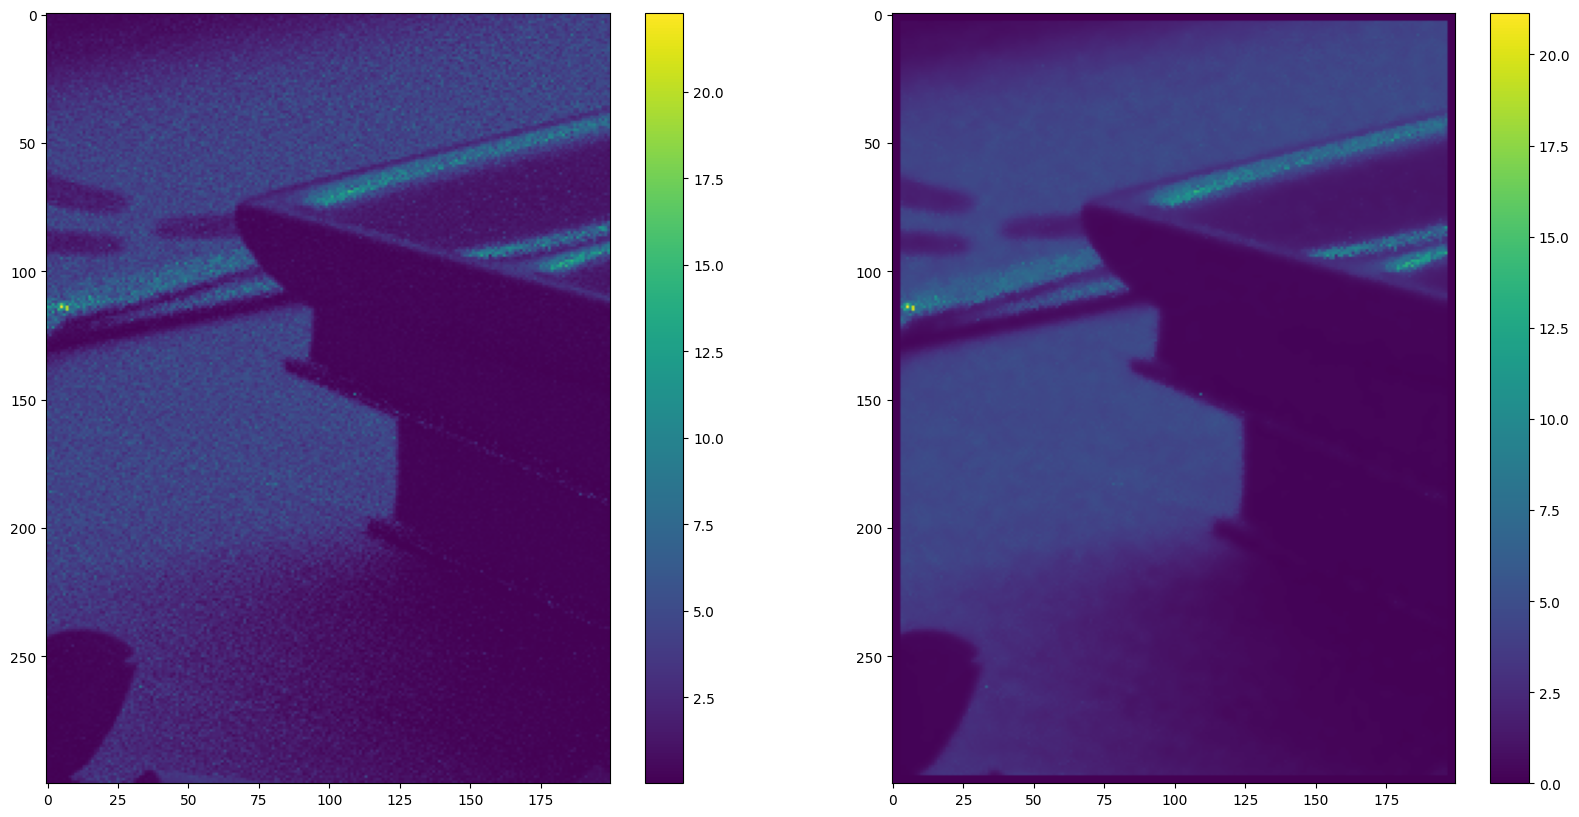

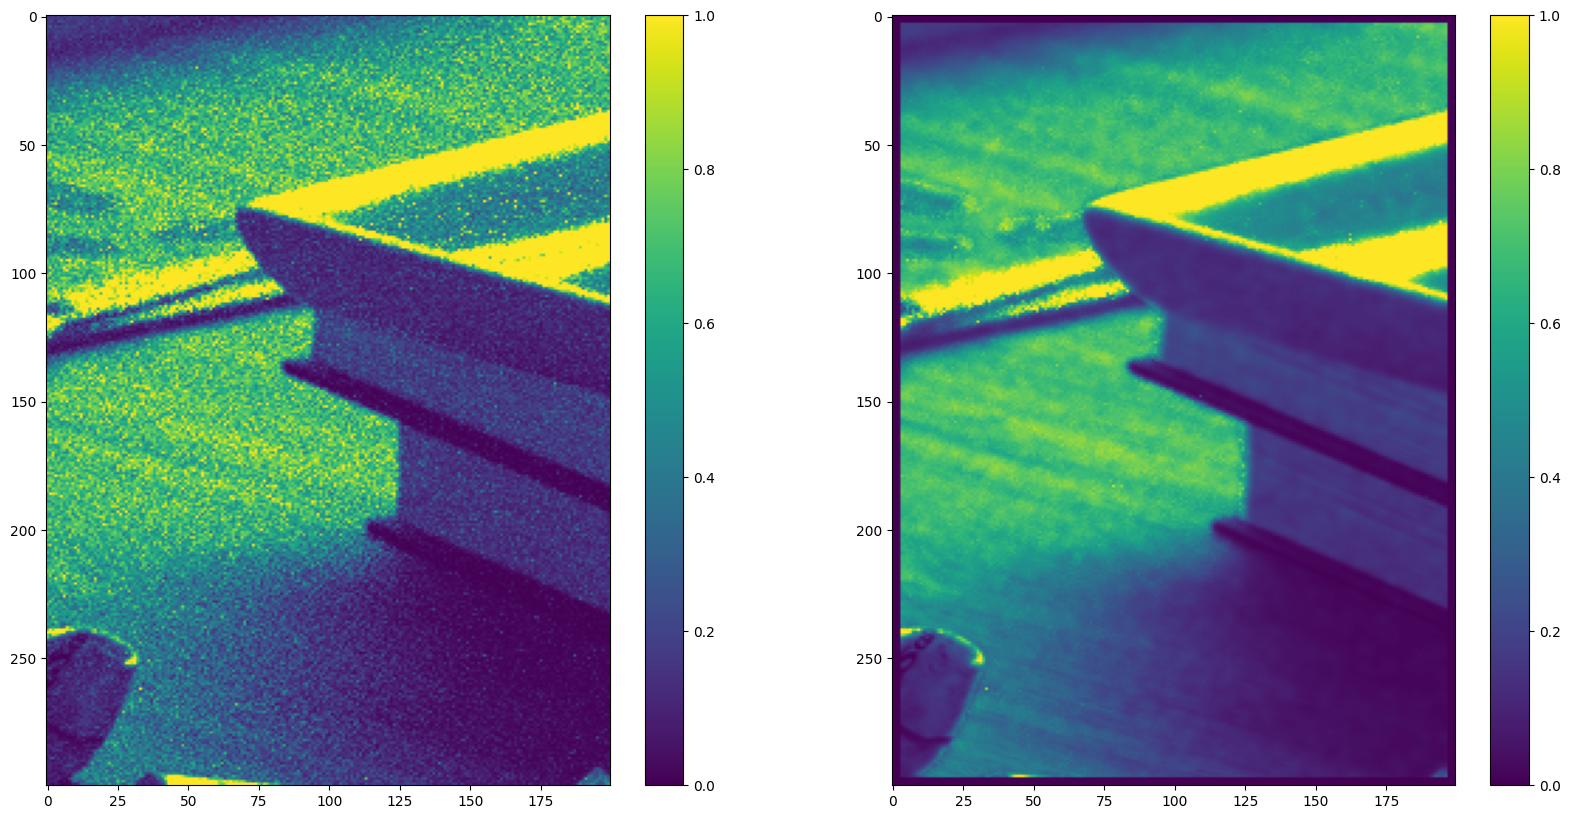

In [42]:
RADIUS = 3
SIDE = 1 + 2 * RADIUS

filtered = np.zeros_like(color)

for y in trange(RADIUS, color.shape[1]-RADIUS):
  for x in range(RADIUS, color.shape[0]-RADIUS):
    value = 0
    ss = 0
    for dy in range(-RADIUS, RADIUS+1):
      for dx in range(-RADIUS, RADIUS+1):
        xx, yy = x + dx, y + dy
        add = 1
        add *= np.exp((dx ** 2 + dy ** 2) * (-1.0 / (2 * RADIUS + 1))) # space
        add *= np.exp(((z[xx, yy] - z[x, y])**2) * (-1.0 / 12.0)) # intensity
        add *= np.exp(((color[xx, yy] - color[x, y])**2) * (-1.0 / 1.0)) # color
        #ncross = np.cross(normals[xx,yy], normals[x,y])
        #ncross = ncross.dot(ncross)
        #add *= gauss(RADIUS * ncross, 0.1) # normal

        value += add * z[xx, yy]
        ss += add

    filtered[x,y] = value / ss

showN([z, filtered], vmin=None, vmax=None)
filtered *= albedo
showN([color, filtered], vmin=0, vmax=1)
#plot_surface(filtered)